# ImageGen using Stable difussion

In [ ]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2


In [ ]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [ ]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='your_hugging_face_auth_token', guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

In [ ]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image


In [ ]:
generate_image("boy chilling in home", image_gen_model)

In [ ]:
image_gen_model.resize((64,64))
image_gen_model.save('phot.jpg')

# Deep steganography

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3

In [ ]:
import numpy as np
import tensorflow as tf
import PIL
from PIL import  Image
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, n_layers, filters=50, kernel_size=(3, 3), activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.convs = []
        for conv in range(n_layers):
            self.convs.append(
                tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
            )

    def call(self, input_tensor, training=False):
        x = self.convs[0](input_tensor, training=training)
        for i in range(1, len(self.convs)):
            x = self.convs[i](x, training=training)

        return x

In [ ]:
class PrepLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

    def call(self, input_tensor, training=False):
        prep_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor.shape)(input_tensor)
        conv_4_3x3 = self.conv_layer_4_3x3(prep_input, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(prep_input, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(prep_input, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        return self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

In [ ]:
class HideLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_3 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):
        prep_input = input_tensor[0]
        hide_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor[1].shape)(input_tensor[1])
        concat_1 = self.concat_1([prep_input, hide_input])

        conv_4_3x3 = self.conv_layer_4_3x3(concat_1, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(concat_1, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(concat_1, training=training)

        concat_2 = self.concat_2([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_2)
        conv_1_4x4 =  self.conv_1_4x4(concat_2)
        conv_1_5x5 =  self.conv_1_5x5(concat_2)

        concat_3 = self.concat_3([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_3)

In [ ]:
class RevealLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):

        conv_4_3x3 = self.conv_layer_4_3x3(input_tensor, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(input_tensor, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(input_tensor, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        concat_2 = self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_2)

In [ ]:
class MyModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.hide_layer = HideLayer()
        self.reveal_layer = RevealLayer()

    def call(self, input_tensor, training=False):
        secret = input_tensor[0]
        cover = input_tensor[1]
        prep_output = self.prep_layer(secret)
        hide_output = self.hide_layer([prep_output, cover])
        reveal_output = self.reveal_layer(hide_output)

        return  reveal_output, hide_output

    def model(self, inputs):
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs))

In [ ]:
class StenographyLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        beta = tf.constant(self.beta, name='beta')

        secret_true = y_true[0]
        secret_pred = y_pred[0]

        cover_true = y_true[1]
        cover_pred = y_pred[1]

        secret_mse = tf.losses.MSE(secret_true, secret_pred)
        cover_mse = tf.losses.MSE(cover_true, cover_pred)

        return tf.reduce_mean(cover_mse + beta * secret_mse)/12288

In [ ]:
secret_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_input')
cover_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_input')

model = MyModel().model(inputs=[secret_input, cover_input])

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 secret_input (InputLayer)   [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 prep_layer (PrepLayer)      (None, 64, 64, 150)          758250    ['secret_input[0][0]']        
                                                                                                  
 cover_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 hide_layer (HideLayer)      (None, 64, 64, 3)            1133703   ['prep_layer[0][0]',          
                                                                     'cover_input[0][0]']     

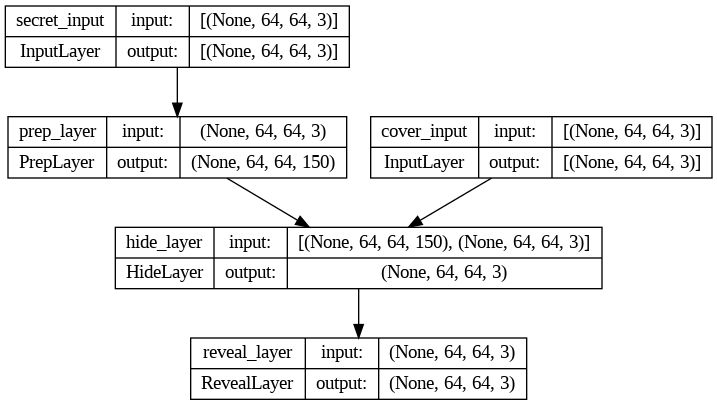

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
optmizer = tf.optimizers.Adam(LEARNING_RATE)
stenography_loss = StenographyLoss(beta=1.0)
def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


model.compile(
    optimizer=optmizer,
    loss=stenography_loss,
    metrics=[peak_signal_noise_ratio]

)

In [ ]:
path = '/content/w/MLprojweight-{epoch:04d}.h5'
model_checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
    filepath = path,
    save_weights_only = True,
    #monitor = 'val_peak_signal_noise_ratio',
    verbose=1,
    #mode = 'auto',
    #save_best_only = False,
    save_freq =   1050         ##10*75 5*25  5*300
)

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("Maysee/tiny-imagenet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split

train_data, _ = train_test_split(dataset['train']['image'], train_size=.15) # Getting a subset of the Tiny ImageNet dataset.

X_train, X_test = train_test_split(train_data, test_size=.1)
X_train_secret, X_train_cover = train_test_split(X_train, test_size=.5)
X_test_secret, X_test_cover = train_test_split(X_test, test_size=.5)
X_val_secret, X_val_cover = train_test_split(dataset['valid']['image'], test_size=.5)

del X_train
del X_test
del train_data

In [ ]:
import matplotlib.pyplot as plt

def show_image(arr):
    plt.imshow(np.array(arr, np.uint8))
    return plt

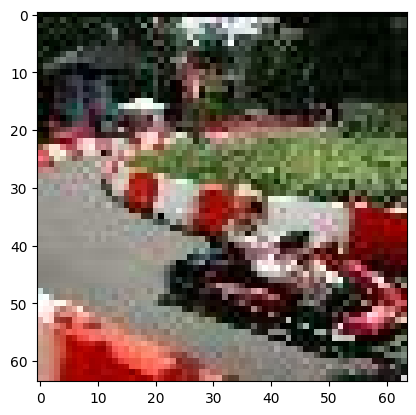

In [ ]:
show_image(X_train_cover[0]).show()

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, secret, cover, batch_size, shuffle=True):
        self.secret = secret
        self.cover = cover
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.datalen = len(secret)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index: int):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        secret_batch = np.array(self.secret)[batch_indexes]
        cover_batch = np.array(self.cover)[batch_indexes]

        return [secret_batch, cover_batch], [secret_batch, cover_batch]

    def __len__(self):
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
for i in range(len(X_train_secret)):
    X_train_secret[i] = tf.keras.utils.img_to_array(X_train_secret[i].convert('RGB'))
    X_train_cover[i] = tf.keras.utils.img_to_array(X_train_cover[i].convert('RGB'))

for i in range(len(X_test_secret)):
    X_test_secret[i] = tf.keras.utils.img_to_array(X_test_secret[i].convert('RGB'))
    X_test_cover[i] = tf.keras.utils.img_to_array(X_test_cover[i].convert('RGB'))

for i in range(len(X_val_secret)):
    X_val_secret[i] = tf.keras.utils.img_to_array(X_val_secret[i].convert('RGB'))
    X_val_cover[i] = tf.keras.utils.img_to_array(X_val_cover[i].convert('RGB'))

In [ ]:
train_gen = DataGenerator(X_train_secret, X_train_cover, BATCH_SIZE)
test_gen = DataGenerator(X_test_secret, X_test_cover, BATCH_SIZE, shuffle=False)
val_gen = DataGenerator(X_val_secret, X_val_cover, BATCH_SIZE, shuffle=False)

In [ ]:
print(len(X_train_secret))

6750


Epoch 1/20
210/210 [==============================] - 154s 598ms/step - loss: 1.8373 - reveal_layer_loss: 0.8991 - hide_layer_loss: 0.9382 - reveal_layer_peak_signal_noise_ratio: 11.8037 - hide_layer_peak_signal_noise_ratio: 11.8923 - val_loss: 1.0680 - val_reveal_layer_loss: 0.5901 - val_hide_layer_loss: 0.4779 - val_reveal_layer_peak_signal_noise_ratio: 12.9292 - val_hide_layer_peak_signal_noise_ratio: 13.8454
Epoch 2/20
210/210 [==============================] - 128s 608ms/step - loss: 0.7711 - reveal_layer_loss: 0.4615 - hide_layer_loss: 0.3096 - reveal_layer_peak_signal_noise_ratio: 14.2489 - hide_layer_peak_signal_noise_ratio: 15.7632 - val_loss: 0.5067 - val_reveal_layer_loss: 0.3183 - val_hide_layer_loss: 0.1884 - val_reveal_layer_peak_signal_noise_ratio: 15.6756 - val_hide_layer_peak_signal_noise_ratio: 18.1345
Epoch 3/20
210/210 [==============================] - 129s 614ms/step - loss: 0.4943 - reveal_layer_loss: 0.2940 - hide_layer_loss: 0.2002 - reveal_layer_peak_signal_no

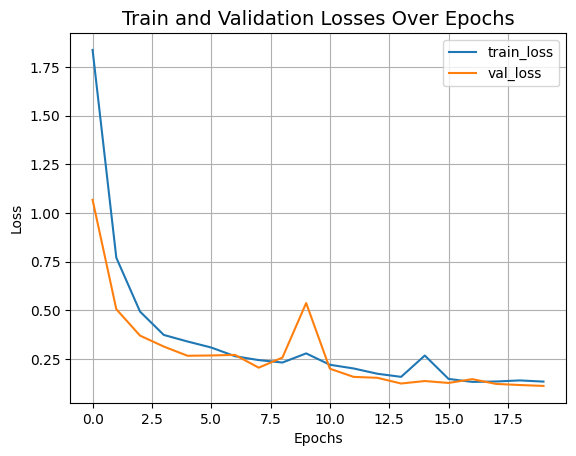

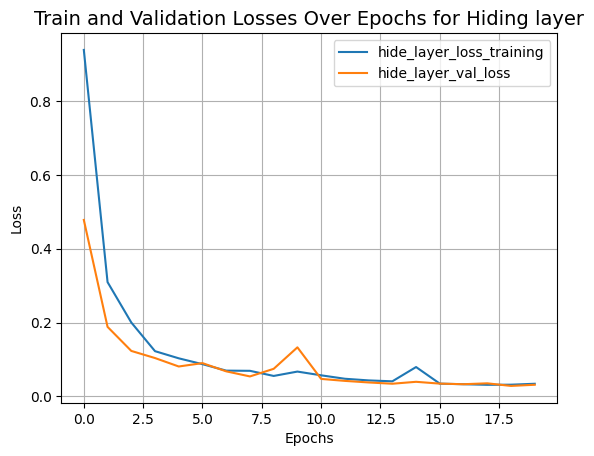

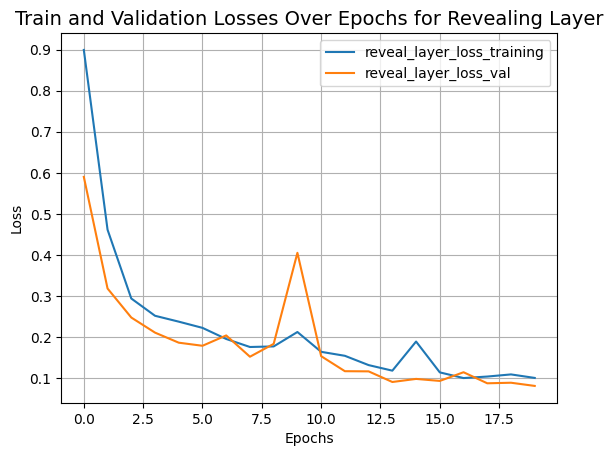

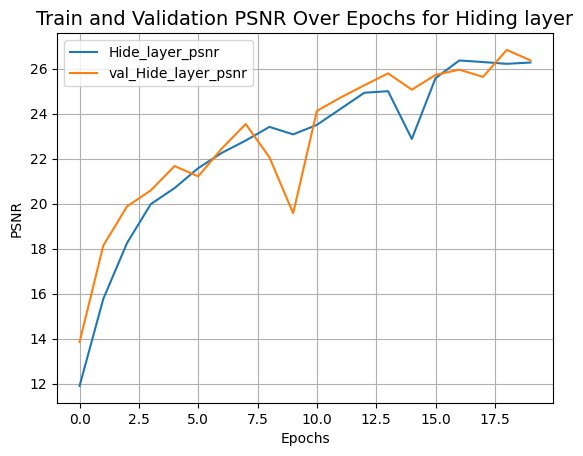

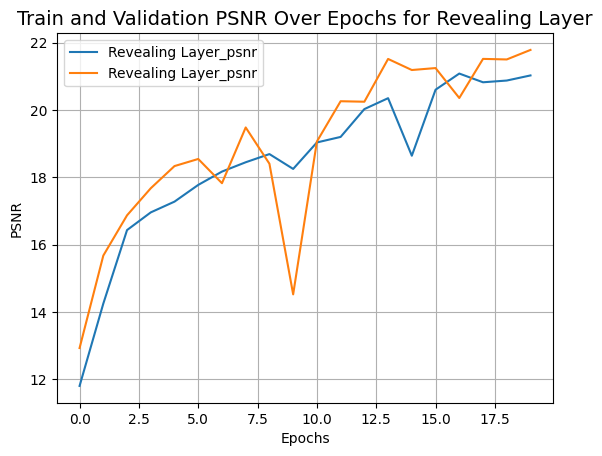

In [ ]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    verbose=1,
    shuffle=True,
    callbacks=[model_checkpoint_callback]

)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["hide_layer_loss"], label="hide_layer_loss_training")
plt.plot(history.history["val_hide_layer_loss"], label="hide_layer_val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["reveal_layer_loss"], label="reveal_layer_loss_training")
plt.plot(history.history["val_reveal_layer_loss"], label="reveal_layer_loss_val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()




plt.plot(history.history["hide_layer_peak_signal_noise_ratio"], label="Hide_layer_psnr")
plt.plot(history.history["val_hide_layer_peak_signal_noise_ratio"], label="val_Hide_layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.plot(history.history["val_reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()




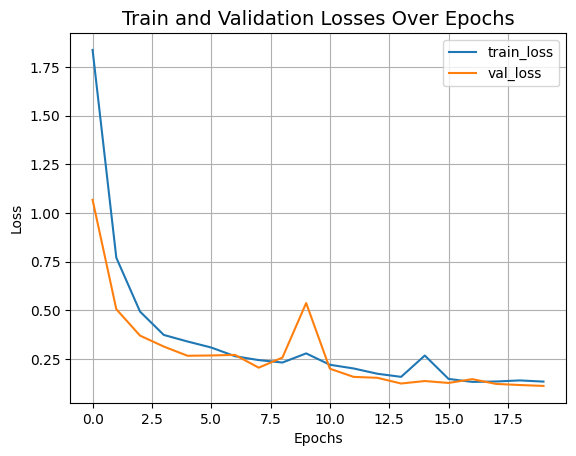

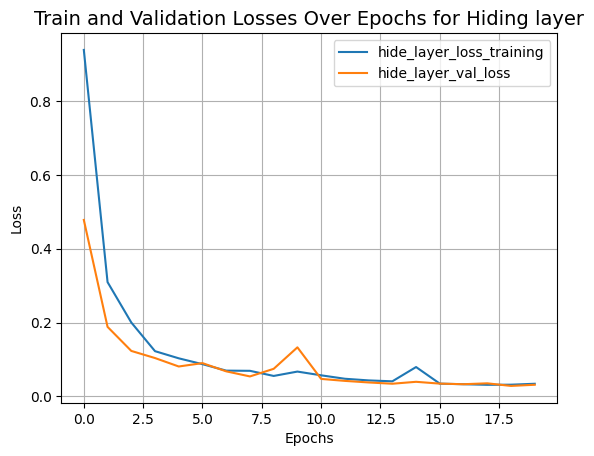

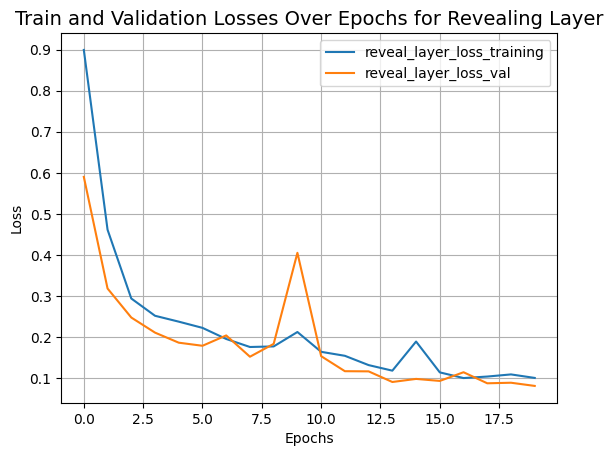

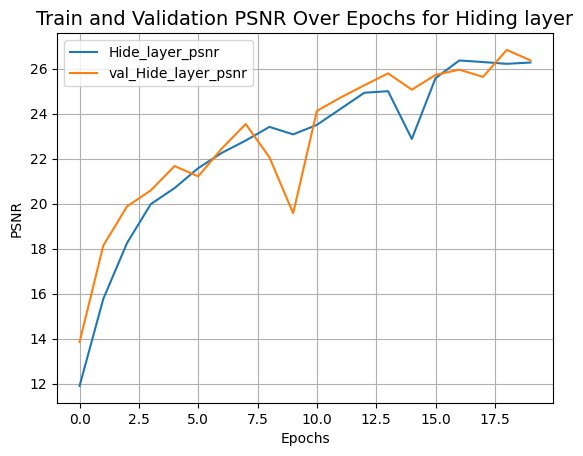

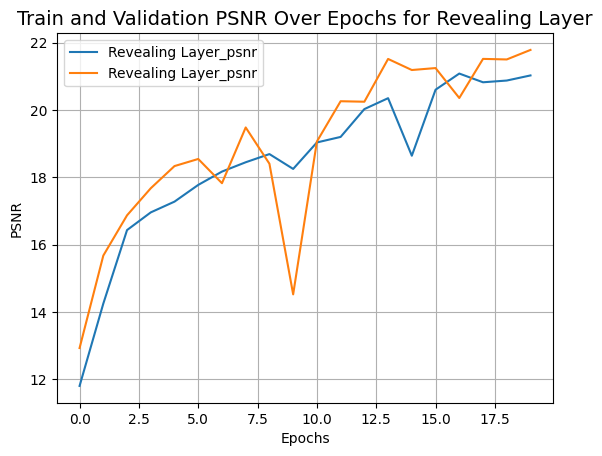

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["hide_layer_loss"], label="hide_layer_loss_training")
plt.plot(history.history["val_hide_layer_loss"], label="hide_layer_val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["reveal_layer_loss"], label="reveal_layer_loss_training")
plt.plot(history.history["val_reveal_layer_loss"], label="reveal_layer_loss_val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()




plt.plot(history.history["hide_layer_peak_signal_noise_ratio"], label="Hide_layer_psnr")
plt.plot(history.history["val_hide_layer_peak_signal_noise_ratio"], label="val_Hide_layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.plot(history.history["val_reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.load_weights('/content/MLprojweight-0020.h5')

Epoch 21/75
210/210 [==============================] - 157s 613ms/step - loss: 0.1504 - reveal_layer_loss: 0.1137 - hide_layer_loss: 0.0368 - reveal_layer_peak_signal_noise_ratio: 21.3539 - hide_layer_peak_signal_noise_ratio: 26.0253 - val_loss: 0.1080 - val_reveal_layer_loss: 0.0786 - val_hide_layer_loss: 0.0294 - val_reveal_layer_peak_signal_noise_ratio: 22.7287 - val_hide_layer_peak_signal_noise_ratio: 26.9302
Epoch 22/75
210/210 [==============================] - 127s 603ms/step - loss: 0.1233 - reveal_layer_loss: 0.0888 - hide_layer_loss: 0.0345 - reveal_layer_peak_signal_noise_ratio: 21.8233 - hide_layer_peak_signal_noise_ratio: 26.4052 - val_loss: 0.1130 - val_reveal_layer_loss: 0.0822 - val_hide_layer_loss: 0.0309 - val_reveal_layer_peak_signal_noise_ratio: 22.5026 - val_hide_layer_peak_signal_noise_ratio: 26.7561
Epoch 23/75
210/210 [==============================] - 127s 604ms/step - loss: 0.1642 - reveal_layer_loss: 0.1247 - hide_layer_loss: 0.0395 - reveal_layer_peak_signal

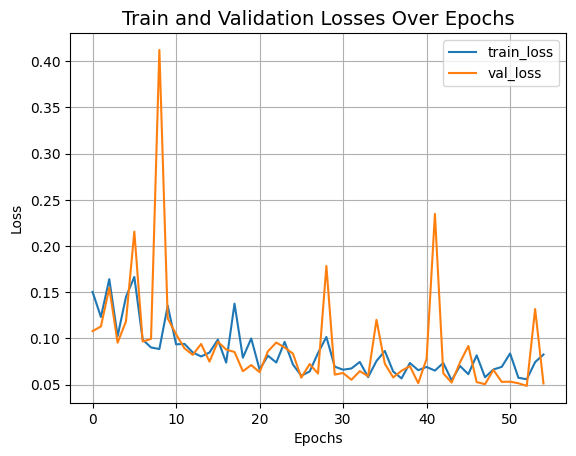

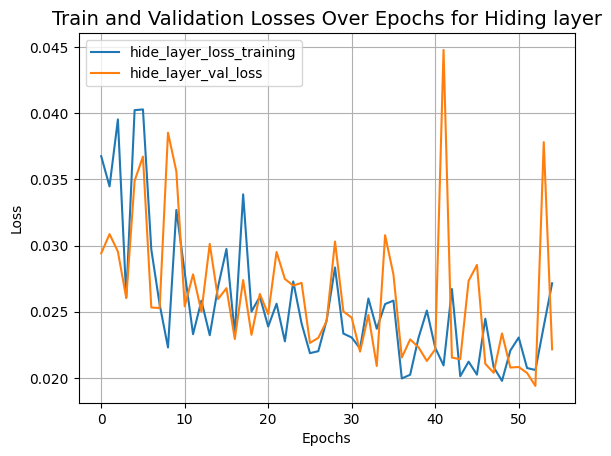

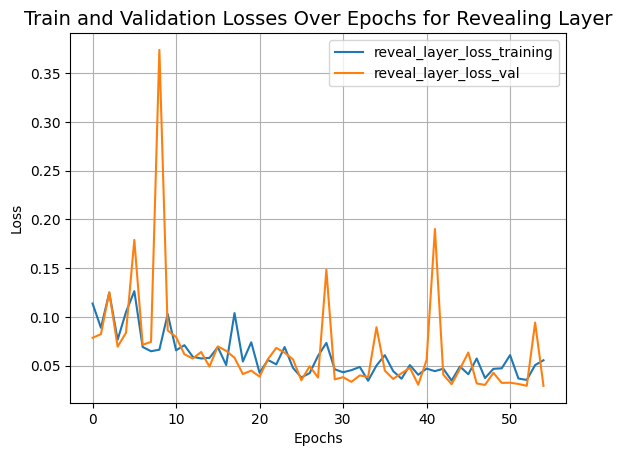

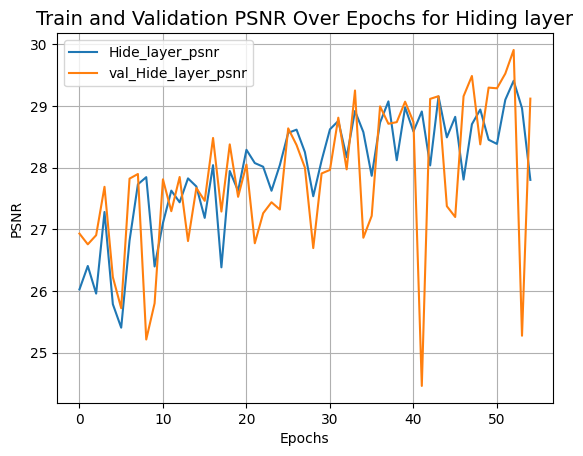

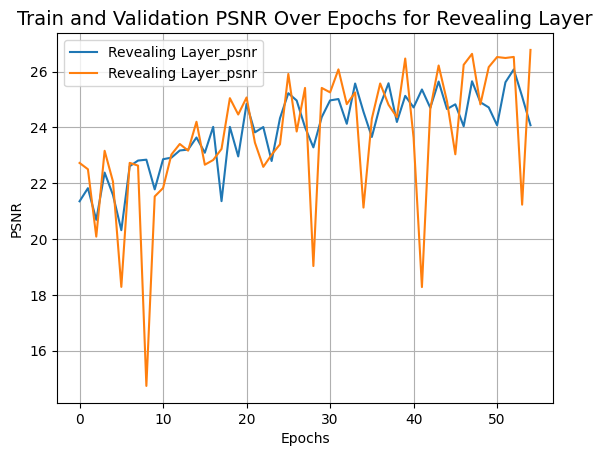

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=75, #75
    initial_epoch=20,
    callbacks=[model_checkpoint_callback]
)


plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["hide_layer_loss"], label="hide_layer_loss_training")
plt.plot(history.history["val_hide_layer_loss"], label="hide_layer_val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["reveal_layer_loss"], label="reveal_layer_loss_training")
plt.plot(history.history["val_reveal_layer_loss"], label="reveal_layer_loss_val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()




plt.plot(history.history["hide_layer_peak_signal_noise_ratio"], label="Hide_layer_psnr")
plt.plot(history.history["val_hide_layer_peak_signal_noise_ratio"], label="val_Hide_layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Hiding layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.plot(history.history["val_reveal_layer_peak_signal_noise_ratio"], label="Revealing Layer_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs for Revealing Layer", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [ ]:
model.save("complete_model.h5", include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(history.history)

{'loss': [0.15040645003318787, 0.12327542155981064, 0.16423887014389038, 0.1025567576289177, 0.1450572907924652, 0.16662728786468506, 0.0987970232963562, 0.0902845710515976, 0.08860641717910767, 0.13554984331130981, 0.09365461766719818, 0.09420622885227203, 0.0848858505487442, 0.08052561432123184, 0.08480212837457657, 0.09869570285081863, 0.0738833099603653, 0.137704536318779, 0.07922612875699997, 0.10006050765514374, 0.06640209257602692, 0.08139187097549438, 0.07401025295257568, 0.09634312987327576, 0.07178021222352982, 0.0596722774207592, 0.06431341916322708, 0.08428308367729187, 0.10163084417581558, 0.06953179091215134, 0.06621915102005005, 0.06754317134618759, 0.07463103532791138, 0.05817221850156784, 0.0756598636507988, 0.0865030586719513, 0.06429028511047363, 0.05676416680216789, 0.07350102066993713, 0.0656658411026001, 0.06919876486063004, 0.0652402862906456, 0.07355189323425293, 0.0547172985970974, 0.07030315697193146, 0.06137021258473396, 0.08174518495798111, 0.058029670268297

In [ ]:
pred = model.predict(test_gen)

23/23 [==============================] - 3s 126ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

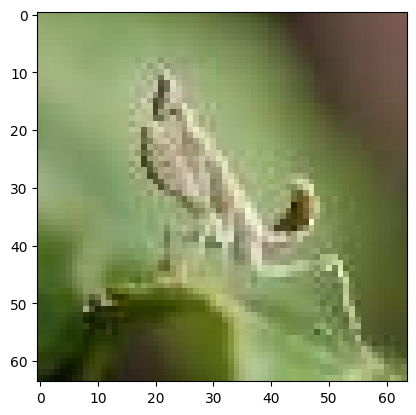

In [ ]:
show_image(X_test_secret[0])  # Secret

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

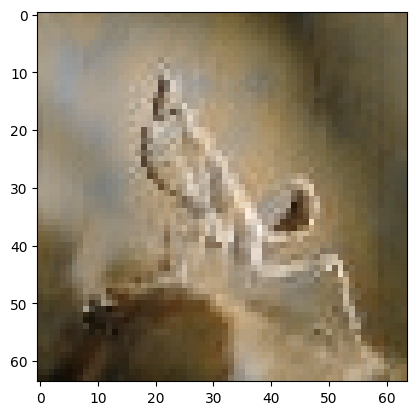

In [ ]:
show_image(pred[0][0])  # Revealed

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

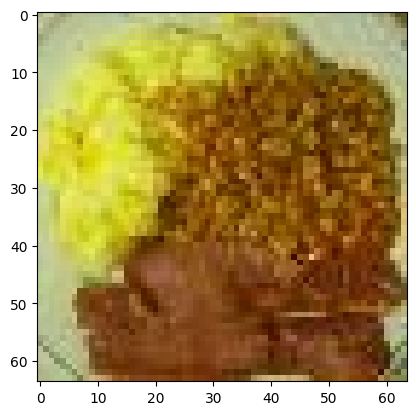

In [ ]:
show_image(X_test_cover[0])  # Cover

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

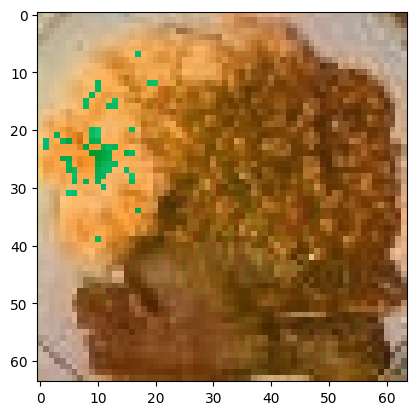

In [ ]:
show_image(pred[1][0])  # Cover with secret

In [ ]:
import PIL

In [ ]:
from PIL import  Image

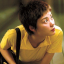

In [ ]:
secret = Image.open('/content/secret.png').convert('RGB')
secret

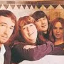

In [ ]:
cover = Image.open('/content/cover.png').convert('RGB')
cover

In [ ]:
revealed, cover_with_secret = model.predict(
    [np.expand_dims(np.array(secret), axis=0), np.expand_dims(np.array(cover), axis=0)]
)

1/1 [==============================] - 1s 1s/step


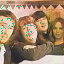

In [ ]:
Image.fromarray(np.array(cover_with_secret[0], dtype=np.uint8), 'RGB')

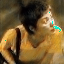

In [ ]:
Image.fromarray(np.array(revealed[0], dtype=np.uint8), 'RGB')